<a href="https://colab.research.google.com/github/francescopapaleo/spring-reverb/blob/main/mir_neural_audio_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring Reverb FX

Sources from https://github.com/csteinmetz1/steerable-nafx/blob/main/steerable-nafx.ipynb

## Setup

In [ ]:
# to avoid encoding errors
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
# package installation
!pip install torchaudio auraloss pyloudnorm soundfile scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# download the pre-trained model
!git clone https://github.com/francescopapaleo/spring-reverb.git

fatal: destination path 'spring-reverb' already exists and is not an empty directory.


In [ ]:
from pathlib import Path

%cd spring-reverb

Path('./output').mkdir(parents=True, exist_ok=True)
Path('./imgs').mkdir(parents=True, exist_ok=True)

/content/gdrive/MyDrive/spring-reverb


In [ ]:
import os
import sys
import math
import torch
import librosa.display
import auraloss
import torchaudio
import numpy as np
import scipy.signal

from google.colab import files
from tqdm.notebook import tqdm
from time import sleep
import IPython.display as ipd
import torch.nn.functional as F

import matplotlib
import pyloudnorm as pyln
import matplotlib.pyplot as plt
%matplotlib inline

## Implementation of the TCN model with FiLM layers for training and inference 

In [ ]:
def causal_crop(x, length: int):
    if x.shape[-1] != length:
        stop = x.shape[-1] - 1
        start = stop - length
        x = x[..., start:stop]
    return x

class FiLM(torch.nn.Module):
    def __init__(
        self,
        cond_dim,  # dim of conditioning input
        num_features,  # dim of the conv channel
        batch_norm=True,
    ):
        super().__init__()
        self.num_features = num_features
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = torch.nn.BatchNorm1d(num_features, affine=False)
        self.adaptor = torch.nn.Linear(cond_dim, num_features * 2)

    def forward(self, x, cond):

        cond = self.adaptor(cond)
        g, b = torch.chunk(cond, 2, dim=-1)
        g = g.permute(0, 2, 1)
        b = b.permute(0, 2, 1)

        if self.batch_norm:
            x = self.bn(x)  # apply BatchNorm without affine
        x = (x * g) + b  # then apply conditional affine

        return x

class TCNBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, dilation, cond_dim=0, activation=True):
    super().__init__()
    self.conv = torch.nn.Conv1d(
        in_channels, 
        out_channels, 
        kernel_size, 
        dilation=dilation, 
        padding=0, #((kernel_size-1)//2)*dilation,
        bias=True)
    if cond_dim > 0:
      self.film = FiLM(cond_dim, out_channels, batch_norm=False)
    if activation:
      #self.act = torch.nn.Tanh()
      self.act = torch.nn.PReLU()
    self.res = torch.nn.Conv1d(in_channels, out_channels, 1, bias=False)

  def forward(self, x, c=None):
    x_in = x
    x = self.conv(x)
    if hasattr(self, "film"):
      x = self.film(x, c)
    if hasattr(self, "act"):
      x = self.act(x)
    x_res = causal_crop(self.res(x_in), x.shape[-1])
    x = x + x_res

    return x

class TCN(torch.nn.Module):
  def __init__(self, n_inputs=1, n_outputs=1, n_blocks=10, kernel_size=13, n_channels=64, dilation_growth=4, cond_dim=0):
    super().__init__()
    self.kernel_size = kernel_size
    self.n_channels = n_channels
    self.dilation_growth = dilation_growth
    self.n_blocks = n_blocks
    self.stack_size = n_blocks

    self.blocks = torch.nn.ModuleList()
    for n in range(n_blocks):
      if n == 0:
        in_ch = n_inputs
        out_ch = n_channels
        act = True
      elif (n+1) == n_blocks:
        in_ch = n_channels
        out_ch = n_outputs
        act = True
      else:
        in_ch = n_channels
        out_ch = n_channels
        act = True
      
      dilation = dilation_growth ** n
      self.blocks.append(TCNBlock(in_ch, out_ch, kernel_size, dilation, cond_dim=cond_dim, activation=act))

  def forward(self, x, c=None):
    for block in self.blocks:
      x = block(x, c)

    return x
  
  def compute_receptive_field(self):
    """Compute the receptive field in samples."""
    rf = self.kernel_size
    for n in range(1, self.n_blocks):
        dilation = self.dilation_growth ** (n % self.stack_size)
        rf = rf + ((self.kernel_size - 1) * dilation)
    return rf

In [ ]:
# Load the pre-trained model
model_verb = torch.load("./models/steinmetz_pretrained.pt", map_location="cpu").eval()

## Pretrained Model: process the validation data

In [ ]:
process_file = './data/Xvalidation.wav'
x_p, sample_rate = torchaudio.load(process_file)
print(process_file, x_p.shape)
ipd.Audio(data=x_p, rate=sample_rate)

Now set the audio effect parameters. Here are some more insights into the controls:

*   `effect_type` - Choose from one of the pre-trained models.
*   `gain_dB` - Adjust the input gain. This can have a big effect since the effects are very nonlinear.
*   `c0` and `c1` - These are the effect controls which will adjust perceptual aspects of the effect, depending on the effect type. Very large values will often result in more extreme effects.
*   `mix` - Control the wet/dry mix of the effect.
*   `width` - Increase stereo width of the effect.
*   `max_length` - If you uploaded a very long file this will truncate it.
*   `stereo` - Convert mono input to stereo output.
*   `tail` - If checked, we will also compute the effect tail (nice for reverbs).
*   `output_file` - Output file path. It avoids overwriting the processed files. 








In [ ]:
gain_dB = 0 #@param {type:"slider", min:-24, max:24, step:0.1}
c0 = -10 #@param {type:"slider", min:-10, max:10, step:0.1}
c1 = -10 #@param {type:"slider", min:-10, max:10, step:0.1}
mix = 100 #@param {type:"slider", min:0, max:100, step:1}
width = 50 #@param {type:"slider", min:0, max:100, step:1}
max_length = 129 #@param {type:"slider", min:5, max:130, step:1}
stereo = False #@param {type:"boolean"}
tail = False #@param {type:"boolean"}
output_file = "./output/processed_pretrained.wav" #@param {type: "string"}

# measure the receptive field
pt_model_rf = model_verb.compute_receptive_field()

# crop input signal if needed
max_samples = int(sample_rate * max_length)
x_p_crop = x_p[:,:max_samples]
chs = x_p_crop.shape[0]

# if mono and stereo requested
if chs == 1 and stereo:
  x_p_crop = x_p_crop.repeat(2,1)
  chs = 2

# pad the input signal
front_pad = pt_model_rf-1
back_pad = 0 if not tail else front_pad
x_p_pad = torch.nn.functional.pad(x_p_crop, (front_pad, back_pad))

# design highpass filter
sos = scipy.signal.butter(
    8, 
    20.0, 
    fs=sample_rate, 
    output="sos", 
    btype="highpass"
)

# compute linear gain 
gain_ln = 10 ** (gain_dB / 20.0)

# process audio with pre-trained model
with torch.no_grad():
  y_hat = torch.zeros(x_p_crop.shape[0], x_p_crop.shape[1] + back_pad)
  for n in range(chs):
    if n == 0:
      factor = (width*5e-3)
    elif n == 1:
      factor = -(width*5e-3)
    c = torch.tensor([float(c0+factor), float(c1+factor)]).view(1,1,-1)
    y_hat_ch = model_verb(gain_ln * x_p_pad[n,:].view(1,1,-1), c)
    y_hat_ch = scipy.signal.sosfilt(sos, y_hat_ch.view(-1).numpy())
    y_hat_ch = torch.tensor(y_hat_ch)
    y_hat[n,:] = y_hat_ch

# pad the dry signal 
x_dry = torch.nn.functional.pad(x_p_crop, (0,back_pad))

# normalize each first
y_hat /= y_hat.abs().max()
x_dry /= x_dry.abs().max()

# mix
mix = mix/100.0
y_hat = (mix * y_hat) + ((1-mix) * x_dry)

# remove transient
y_hat = y_hat[...,8192:]
y_hat /= y_hat.abs().max()

torchaudio.save(output_file, y_hat.view(chs,-1), sample_rate, encoding="PCM_S", bits_per_sample=16)
print("Done.")
print("Sending audio to browser...")

# show the audio
ipd.Audio(output_file)

## 2. Training

In [ ]:
#@title Upload clean sound (x)
#@markdown For training we need very few data, you have to upload the clean input file (without reverb aka `dry` signal) and the processed signal (with reverb aka `wet` signal). You can use `saxophone_input.wav` or any other audio file you want to use for training. Remember the system has a fixed-length, so input and output should have the same duration ☝🏽
input_file = './data/Xtrain.wav'
x, sample_rate = torchaudio.load(input_file)
print(input_file, x.shape)
# ipd.Audio(data=x, rate=sample_rate, autoplay=False)

./data/Xtrain.wav torch.Size([1, 35904000])


In [ ]:
#@title Upload processed sound (y)
output_file = './data/Ytrain_0.wav'
y, sample_rate = torchaudio.load(output_file)

if not y.shape[-1] == x.shape[-1]:
  print(f"Input and output files are different lengths! Found clean: {x.shape[-1]} processed: {y.shape[-1]}.")
  if y.shape[-1] > x.shape[-1]:
    print(f"Cropping target...")
    y = y[:,:x.shape[-1]]
  else:
    print(f"Cropping input...")
    x = x[:,:y.shape[-1]]

print(output_file, y.shape)
# IPython.display.Audio(data=y, rate=sample_rate)
     

./data/Ytrain_0.wav torch.Size([1, 35904000])


Parameters: 3.148 k
Receptive field: 56173 samples or 3510.8 ms
Learning rate schedule: 1:1.00e-03 -> 1999:1.00e-04 -> 2374:1.00e-05


  0%|          | 0/2499 [00:00<?, ?it/s]

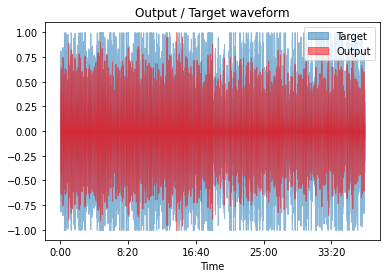

In [ ]:
#@title TCN model training parameters | it should take less than 2 minuts with GPU
#@markdown Now its time to generate the neural spring reverb effect by training the TCN to emulate the input/output function from the target audio effect. Adjusting the parameters will enable you to tweak the optimization process.
cond_dim = 2 #@param {type:"slider", min:1, max:10, step:1}
kernel_size = 13 #@param {type:"slider", min:3, max:32, step:1}
n_blocks = 5 #@param {type:"slider", min:2, max:30, step:1}
dilation_growth = 8 #@param {type:"slider", min:1, max:10, step:1}
n_channels = 8 #@param {type:"slider", min:1, max:128, step:1}
n_iters = 2499 #@param {type:"slider", min:0, max:10000, step:1}
length = 228308 #@param {type:"slider", min:0, max:524288, step:1}
lr = 0.001 #@param {type:"number"}

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

# reshape the audio
x_batch = x.view(1,x.shape[0],-1)
y_batch = y.view(1,y.shape[0],-1)
c = torch.tensor([0.0, 0.0], device=device).view(1,1,-1)

# crop length
x_batch = x_batch[:,0:1,:]
y_batch = y_batch[:,0:1,:]

_, x_ch, x_samp = x_batch.size()
_, y_ch, y_samp = y_batch.size()

# build the model
model = TCN(
    n_inputs=x_ch,
    n_outputs=y_ch,
    cond_dim=cond_dim, 
    kernel_size=kernel_size, 
    n_blocks=n_blocks, 
    dilation_growth=dilation_growth, 
    n_channels=n_channels)
rf = model.compute_receptive_field()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameters: {params*1e-3:0.3f} k")
print(f"Receptive field: {rf} samples or {(rf/sample_rate)*1e3:0.1f} ms")

# setup loss function, optimizer, and scheduler
loss_fn = auraloss.freq.MultiResolutionSTFTLoss(
    fft_sizes=[32, 128, 512, 2048],
    win_lengths=[32, 128, 512, 2048],
    hop_sizes=[16, 64, 256, 1024])
loss_fn_l1 = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr)
ms1 = int(n_iters * 0.8)
ms2 = int(n_iters * 0.95)
milestones = [ms1, ms2]
print(
    "Learning rate schedule:",
    f"1:{lr:0.2e} ->",
    f"{ms1}:{lr*0.1:0.2e} ->",
    f"{ms2}:{lr*0.01:0.2e}",
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones,
    gamma=0.1,
    verbose=False,
)

# move tensors to GPU
if torch.cuda.is_available():
  model.to(device)
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)
  c = c.to(device)

# pad input so that output is same size as input
x_pad = torch.nn.functional.pad(x_batch, (rf-1, 0))

# iteratively update the weights
pbar = tqdm(range(n_iters))
for n in pbar:
  optimizer.zero_grad()

  start_idx = rf #np.random.randint(rf, x_batch.shape[-1]-length-1)
  stop_idx = start_idx + length
  x_crop = x_batch[...,start_idx-rf+1:stop_idx]
  y_crop = y_batch[...,start_idx:stop_idx]

  y_hat = model(x_crop, c)
  loss = loss_fn(y_hat, y_crop) #+ loss_fn_l1(y_hat, y_crop)

  loss.backward()
  optimizer.step()
  
  scheduler.step()
  if (n+1) % 1 == 0:
    pbar.set_description(f" Loss: {loss.item():0.3e} | ")

y_hat /= y_hat.abs().max()

model.eval()
x_pad = torch.nn.functional.pad(x_batch, (rf-1, 0))
with torch.no_grad():
  y_hat = model(x_pad, c)

input = causal_crop(x_batch.view(-1).detach().cpu().numpy(), y_hat.shape[-1])
output = y_hat.view(-1).detach().cpu().numpy()
target = causal_crop(y_batch.view(-1).detach().cpu().numpy(), y_hat.shape[-1])

# apply highpass to output
sos = scipy.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
output = scipy.signal.sosfilt(sos, output)

input /= np.max(np.abs(input))
output /= np.max(np.abs(output))
target /= np.max(np.abs(target))

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(target, sr=sample_rate, alpha=0.5, ax=ax, label='Target')
librosa.display.waveshow(output, sr=sample_rate, color='r', alpha=0.5, ax=ax, label='Output')
plt.title('Output / Target waveform')
plt.savefig('./imgs/output-target.png')
plt.legend()

plt.show(fig)

In [ ]:
#@title Upload input audio to apply your Spring Reverb model
process_file = './data/Xvalidation.wav'
x_p, sample_rate = torchaudio.load(process_file)
print(process_file, x_p.shape)
ipd.Audio(data=x_p, rate=sample_rate)

In [ ]:
#@title Process a new source
gain_dB = 0 #@param {type:"slider", min:-24, max:24, step:0.1}
c0 = -10 #@param {type:"slider", min:-10, max:10, step:0.1}
c1 = -10 #@param {type:"slider", min:-10, max:10, step:0.1}
mix = 100 #@param {type:"slider", min:0, max:100, step:1}
width = 50 #@param {type:"slider", min:0, max:100, step:1}
max_length = 128 #@param {type:"slider", min:5, max:128, step:1}
stereo = False #@param {type:"boolean"}
tail = False #@param {type:"boolean"}
output_file = "./output/processed_out.wav" #@param {type: "string"}

model.eval()
# measure the receptive field
pt_model_rf = model.compute_receptive_field()

# crop input signal if needed
max_samples = int(sample_rate * max_length)
x_p_crop = x_p[:,:max_samples]
chs = x_p_crop.shape[0]

# if mono and stereo requested
if chs == 1 and stereo:
  x_p_crop = x_p_crop.repeat(2, 1)
  chs = 2

# pad the input signal
front_pad = pt_model_rf - 1
back_pad = 0 if not tail else front_pad
x_p_pad = torch.nn.functional.pad(x_p_crop, (front_pad, back_pad))

# design highpass filter
sos = scipy.signal.butter(
    8, 
    20.0, 
    fs=sample_rate, 
    output="sos", 
    btype="highpass"
)

# compute linear gain 
gain_ln = 10 ** (gain_dB / 20.0)

# move data to cuda
x_p_crop = x_p_crop.to(device)
x_p_pad = x_p_pad.to(device)

# process audio with pre-trained model
with torch.no_grad():
  y_hat = torch.zeros(x_p_crop.shape[0], x_p_crop.shape[1] + back_pad, device=device)
  for n in range(chs):
    if n == 0:
      factor = (width * 5e-3)
    elif n == 1:
      factor = -(width * 5e-3)
    c = torch.tensor([float(c0+factor), float(c1+factor)], device=device).view(1, 1, -1).float()
    y_hat_ch = model(gain_ln * x_p_pad[n, :].view(1, 1, -1), c).cpu()
    y_hat_ch = scipy.signal.sosfilt(sos, y_hat_ch.view(-1).numpy())
    y_hat_ch = torch.tensor(y_hat_ch)
    y_hat[n,:] = y_hat_ch

# pad the dry signal 
x_dry = torch.nn.functional.pad(x_p_crop, (0, back_pad))

# normalize each first
y_hat /= y_hat.abs().max()
x_dry /= x_dry.abs().max()

# mix
mix = mix / 100.0
y_hat = (mix * y_hat) + ((1 - mix) * x_dry)

# remove transient
y_hat = y_hat[..., 8192:]
y_hat /= y_hat.abs().max()

torchaudio.save(output_file, y_hat.view(chs, -1).to("cpu"), sample_rate, encoding="PCM_S", bits_per_sample=16)
print("Done.")
print("Sending audio to browser...")

# show the audio
ipd.Audio(output_file)

In [ ]:
# #@title Save and load your spring model to inference with CPU
# model_fn = "my_spring_reverb_model.pt"
# torch.save(model, model_fn)
# my_spring_reverb_model = torch.load(model_fn)

In [ ]:
def error_to_signal(y, y_pred):
    """
    Error to signal ratio with pre-emphasis filter:
    https://www.mdpi.com/2076-3417/10/3/766/htm
    """
    # y, y_pred = pre_emphasis_filter(y), pre_emphasis_filter(y_pred)
    
    # Pad inputs to same size
    max_len = max(y.shape[1], y_pred.shape[1])
    y = F.pad(y, (0, max_len - y.shape[1]))
    y_pred = F.pad(y_pred, (0, max_len - y_pred.shape[1]))
    
    # Compute error to signal ratio
    error = torch.sum(torch.pow(y - y_pred, 2))
    signal = torch.sum(torch.pow(y, 2))
    esr = error / (signal + 1e-10)
    return esr


def pre_emphasis_filter(x, coeff=0.95):
    return torch.cat((x[:, 0:1], x[:, 1:] - coeff * x[:, :-1]), dim=1)


def mean_square_error(y, y_pred):
    """
    Compute mean square error between y and y_pred
    """
    # Pad inputs to same size
    max_len = max(y.shape[1], y_pred.shape[1])
    y = F.pad(y, (0, max_len - y.shape[1]))
    y_pred = F.pad(y_pred, (0, max_len - y_pred.shape[1]))
    
    # Compute mean square error
    mse = F.mse_loss(y_pred, y)
    
    return mse.item()

In [ ]:
ground_truth = './data/Yvalidation_0.wav'
pred_1 = './output/processed_pretrained.wav'
pred_2 = './output/processed_out.wav'

print(torchaudio.info(ground_truth))
print(torchaudio.info(pred_1))
print(torchaudio.info(pred_2))

gt, sr = torchaudio.load(ground_truth)
p1, sr = torchaudio.load(pred_1)
p2, sr = torchaudio.load(pred_2)

max_len = max(gt.shape[-1], p1.shape[-1], p2.shape[-1])

# Pad the waveforms with zeros to the length of the longest waveform
gt = torch.nn.functional.pad(gt, (0, max_len-gt.shape[-1]), 'constant', 0)
p1 = torch.nn.functional.pad(p1, (0, max_len-p1.shape[-1]), 'constant', 0)
p2 = torch.nn.functional.pad(p2, (0, max_len-p2.shape[-1]), 'constant', 0)

p1_esr = error_to_signal(gt, p1)
p2_esr = error_to_signal(gt, p2)

print(f"First model ESR: {p1_esr}")
print(f"Second model ESR: {p2_esr}")

mse_1 = mean_square_error(gt, p1)
mse_2 = mean_square_error(gt, p2)

print(f"First model MSE: {mse_1}")
print(f"Second model MSE: {mse_2}")

AudioMetaData(sample_rate=16000, num_frames=2048000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
AudioMetaData(sample_rate=16000, num_frames=2039808, num_channels=1, bits_per_sample=16, encoding=PCM_S)
AudioMetaData(sample_rate=16000, num_frames=2039808, num_channels=1, bits_per_sample=16, encoding=PCM_S)
First model ESR: 2.087594509124756
Second model ESR: 1.1785094738006592
First model MSE: 0.09030959755182266
Second model MSE: 0.05098246783018112


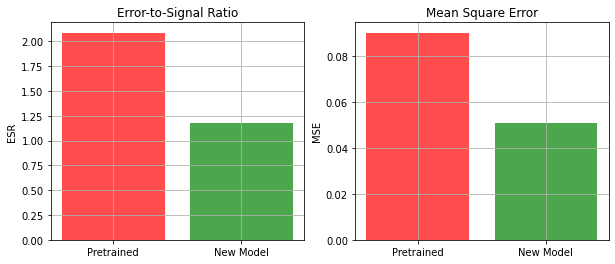

In [ ]:
# Set data
labels = ['Pretrained', 'New Model']
esr = [p1_esr, p2_esr]
mse = [mse_1, mse_2]
colors = ['red', 'green',]

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# Plot bar charts
ax1.bar(labels, esr, color=colors, alpha=0.7)
ax2.bar(labels, mse, color=colors, alpha=0.7)

# Set titles and labels
ax1.set_title('Error-to-Signal Ratio')
ax1.set_ylabel('ESR')
ax1.grid(True)

ax2.set_title('Mean Square Error')
ax2.set_ylabel('MSE')
ax2.grid(True)

# Display the plot
plt.savefig('./imgs/bars.png')
plt.show()

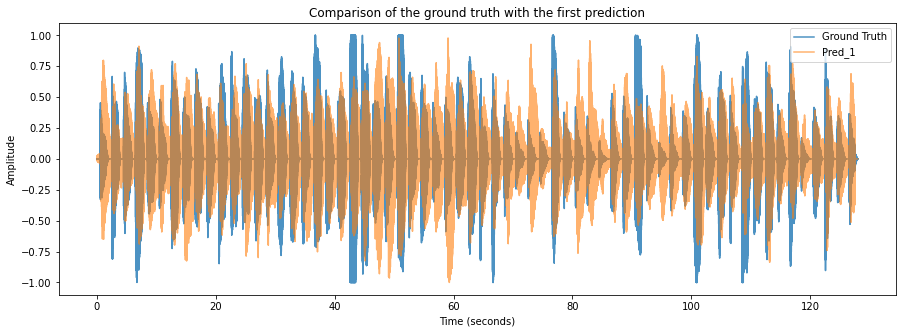

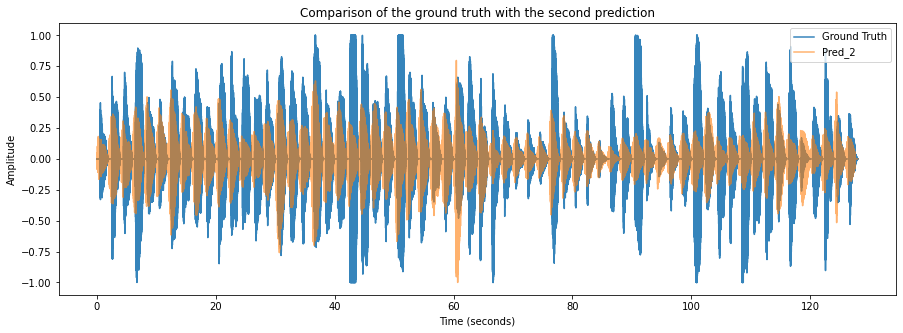

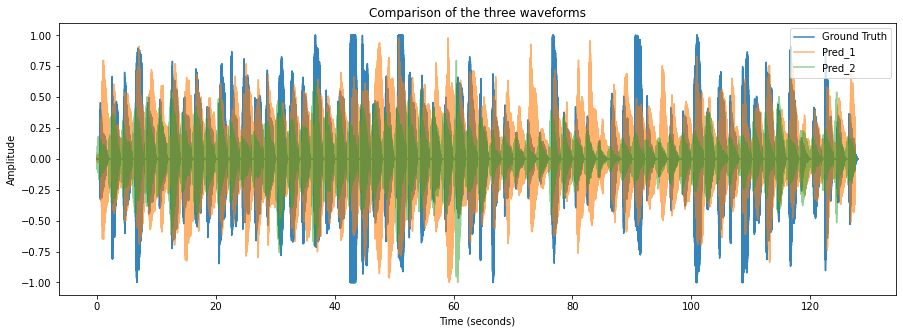

In [ ]:
# Compute the time axis and waveform arrays
time_axis = torch.linspace(0, gt.shape[-1]/sr, gt.shape[-1])
waveform_arrays = [gt[0], p1[0], p2[0]]

plt.figure(figsize=(15, 5))
plt.title("Comparison of the ground truth with the first prediction")
plt.plot(time_axis, waveform_arrays[0], label='Ground Truth', alpha=0.8)
plt.plot(time_axis, waveform_arrays[1], label='Pred_1', alpha=0.6)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.savefig('./imgs/gt-p1.png')
plt.show()

plt.figure(figsize=(15, 5))
plt.title("Comparison of the ground truth with the second prediction")
plt.plot(time_axis, waveform_arrays[0], label='Ground Truth', alpha=0.9)
plt.plot(time_axis, waveform_arrays[2], label='Pred_2', alpha=0.6)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.savefig('./imgs/gt-p2.png')
plt.show()

plt.figure(figsize=(15, 5))
plt.title("Comparison of the three waveforms")
plt.plot(time_axis, waveform_arrays[0], label='Ground Truth', alpha=0.9)
plt.plot(time_axis, waveform_arrays[1], label='Pred_1', alpha=0.6)
plt.plot(time_axis, waveform_arrays[2], label='Pred_2', alpha=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.savefig('./imgs/gt-p1-p2.png')
plt.show()
